In [63]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from matplotlib import pylab as plt
import seaborn as sns

In [66]:
df = pd.read_csv('diabetes_data.csv', delimiter=';')

In [3]:
df

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,Male,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,Male,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,Male,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,Male,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,Male,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1
516,48,Female,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1
517,58,Female,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1
518,32,Female,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0


#### As we can see there is no NA values in dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 520 non-null    int64 
 1   gender              520 non-null    object
 2   polyuria            520 non-null    int64 
 3   polydipsia          520 non-null    int64 
 4   sudden_weight_loss  520 non-null    int64 
 5   weakness            520 non-null    int64 
 6   polyphagia          520 non-null    int64 
 7   genital_thrush      520 non-null    int64 
 8   visual_blurring     520 non-null    int64 
 9   itching             520 non-null    int64 
 10  irritability        520 non-null    int64 
 11  delayed_healing     520 non-null    int64 
 12  partial_paresis     520 non-null    int64 
 13  muscle_stiffness    520 non-null    int64 
 14  alopecia            520 non-null    int64 
 15  obesity             520 non-null    int64 
 16  class               520 no

#### Class balance in dataset

In [58]:
df['class'].value_counts(normalize=True)

1    0.615385
0    0.384615
Name: class, dtype: float64

#### Age feature discribe

In [7]:
df.age.describe()

count    520.000000
mean      48.028846
std       12.151466
min       16.000000
25%       39.000000
50%       47.500000
75%       57.000000
max       90.000000
Name: age, dtype: float64

#### Almost normal distributed

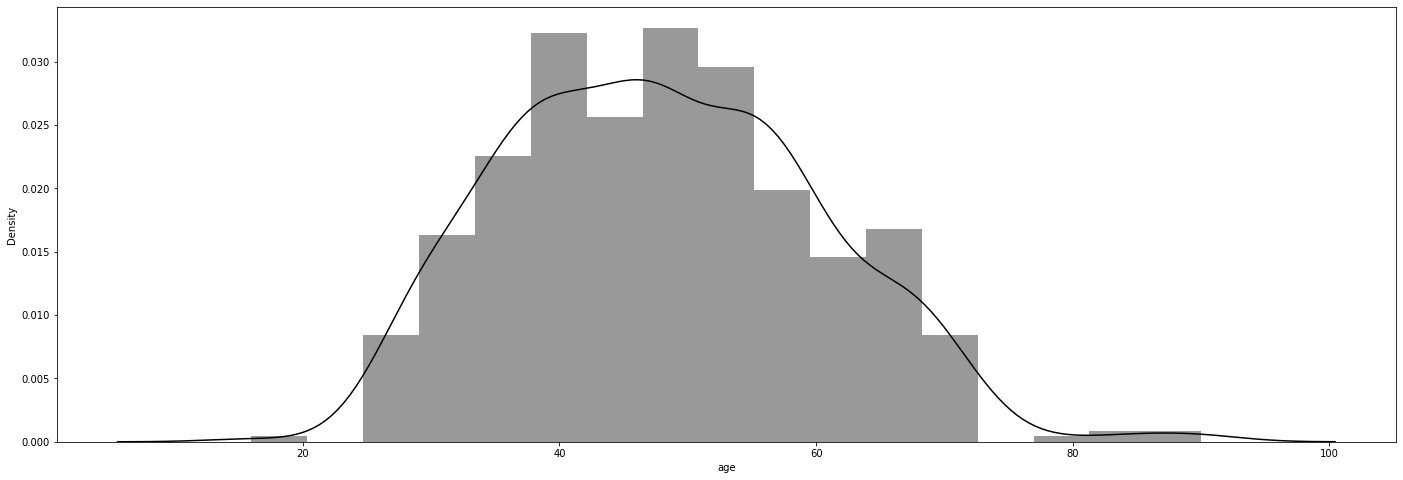

In [70]:
plt.figure(figsize=(24, 8))
sns.distplot(df['age'], kde=True, color="black");

#### Gender Distribution by target

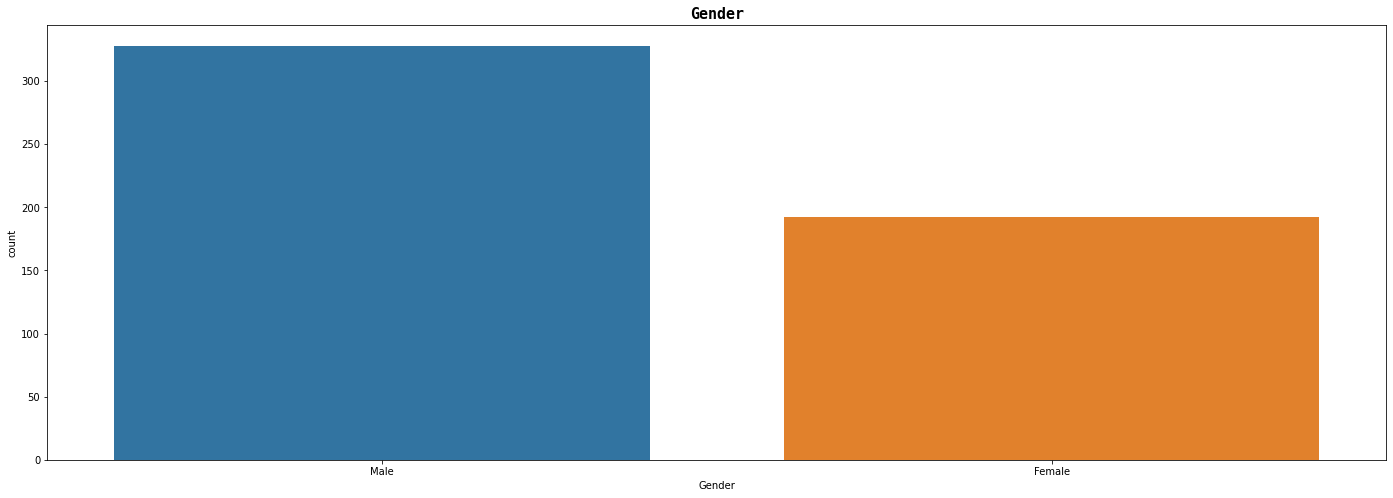

In [67]:
# let's plot it
plt.figure(figsize=(24, 8)) # figuring the size
# makes count plot 
sns.countplot(x='gender', data=df)
# title
plt.title('Gender', fontname='monospace', fontweight='bold', fontsize=15)
# x-label
plt.xlabel('Gender');

In [8]:
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

#### Lets check feature importance with base Random forest classifier and mutual scoring

In [14]:
rf = RandomForestClassifier(random_state=17)

In [15]:
rf.fit(X, y)

RandomForestClassifier(random_state=17)

In [34]:
feature_importances = rf.feature_importances_
fi = pd.DataFrame.from_dict(dict(zip(df.drop('class', 1).columns, feature_importances)), orient='index', columns=['importance'])
fi = fi.sort_values('importance', ascending=False).reset_index()

def mutual_info(col):
    return mutual_info_score(col, df['class'])


fi = fi.merge(df.drop('class', 1).apply(mutual_info).reset_index(), 'inner', 'index')
fi.columns = ['column', 'fi_random_forest', 'fi_mutual_score']


#### So, as we can see feature importance by random forest and mutual score are almost the same 

In [35]:
fi

,column,fi_random_forest,fi_mutual_score
0,polydipsia,0.224613,0.248879
1,polyuria,0.214710,0.251093
2,gender,0.103543,0.113274
3,age,0.089546,0.168542
4,sudden_weight_loss,0.051381,0.103121
5,irritability,0.043624,0.050512
6,alopecia,0.041266,0.035464
7,partial_paresis,0.038562,0.100266
8,delayed_healing,0.030572,0.001105
9,polyphagia,0.029421,0.060888


### Dividing data on train/test

In [57]:
X = df.drop('class', 1).values
y = df['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=17, stratify=y)
X_train.shape, X_test.shape

((416, 16), (104, 16))

### Lets build several models and tune them on cross-validation with GridSearch

In [48]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

log_reg = {'classifier': [LogisticRegression(random_state=17, max_iter=1000, class_weight='balanced')],
           'classifier__C': [0.001, 0.01, 0.1, 1, 3, 10, 100]
          }

svc = {'classifier': [SVC(class_weight='balanced', random_state=17)],
       'classifier__C': [0.001, 0.01, 0.1, 1, 3, 10, 100]
      }

gbc = {'classifier': [GradientBoostingClassifier(random_state=17)],
       'classifier__n_estimators': [100, 200, 300, 400, 500],
       'classifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]
      }

rf = {'classifier': [RandomForestClassifier(random_state=17, )],
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]
     }

pipe = Pipeline([("classifier", LogisticRegression())])

grid = GridSearchCV(pipe, [log_reg, svc, gbc, rf], scoring='accuracy', n_jobs=-1, cv=skf, verbose=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 104 candidates, totalling 520 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(class_weight='balanced',
                                                            max_iter=1000,
                                                            random_state=17)],
                          'classifier__C': [0.001, 0.01, 0.1, 1, 3, 10, 100]},
                         {'classifier': [SVC(class_weight='balanced',
                                             random_state=...
                          'classifier__C': [0.001, 0.01, 0.1, 1, 3, 10, 100]},
                         {'classifier': [GradientBoostingClassifier(max_depth=4,
                                                                    random_state=17)],
                          'classifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'classifier__n_est

#### Best score

In [46]:
grid.best_score_

0.9807515777395295

#### Best params

In [47]:
grid.best_params_

{'classifier': GradientBoostingClassifier(max_depth=4, random_state=17),
 'classifier__max_depth': 4,
 'classifier__n_estimators': 100}

### Lets check on our best model on test data

In [54]:
preds = grid.best_estimator_['classifier'].predict(X_test)

### Model performance on test data is almost the same

In [55]:
accuracy_score(y_test, preds)

0.9711538461538461